# Macro-Credit Regime Radar

Detects “risk-on / risk-off” market regimes by linking macro fundamentals and credit conditions to asset returns. Data come from FRED (growth, labor, rates/funding stress, credit spreads, housing) and Yahoo Finance (SPY, HYG, LQD, MBB, SH). All series are aligned to weekly (Friday) frequency; monthly releases are forward-filled. Features include YoY transforms (via FRED units) and rolling z-scores for comparability. A Markov Regime Switching model (`MarkovRegression`) infers latent regimes, and performance is evaluated with ROC-AUC plus precision/recall for stress episodes.

* **Inputs:** FRED indicators; ETF proxies for risk, credit, duration, and hedges.
* **Processing:** Weekly alignment, standardization (z-scores), simple derived metrics.
* **Modeling:** 2–3 state regime switching; regime probabilities drive overlays, scenarios, and evaluation.


In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data and models
import yfinance as yf
from fredapi import Fred
from fred_api_key import API_KEY  # <-- your local module with API_KEY defined
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Display / plotting defaults
pd.set_option("display.width", 150)
pd.set_option("display.max_columns", 50)
plt.rcParams.update({"figure.figsize": (11, 5), "axes.grid": True})

# FRED client and time setup
fred  = Fred(api_key=API_KEY)
# captures 2008 + COVID + hiking cycle
START = "2002-01-01"   
FREQ  = "W-FRI"# align to market week (Friday closes)


### Analysis configuration: FRED client, series map, and helper utilities

* **Creates a FRED client** using your `API_KEY` and defines the analysis **time window** (`START = "2002-01-01"`) plus the **weekly Friday frequency** (`FREQ = "W-FRI"`).
* **Maps friendly names to FRED series** in `FRED_SERIES`, including built-in unit transforms (e.g., `"pc1"` for YoY % change).
* **Sets two helper functions:**

  * `weekly_align(...)` → resamples any DataFrame to **weekly Friday** and forward-fills to line up mixed-frequency series.
  * `zscore(...)` → standardizes columns to z-scores so heterogeneous indicators are comparable on the same scale.
* Alongside that, you already set **pandas display options** and **matplotlib defaults** earlier to make tables wider and plots consistent.

In [3]:
# Friendly names -> (FRED series ID, units transform)
FRED_SERIES = {
    # Growth / consumption
    "PCE_yoy"          : ("PCE", "pc1"),      # personal consumption, %YoY
    "RetailSales_yoy"  : ("RSAFS", "pc1"),    # advance retail sales, %YoY
    # Labor market
    "UnemploymentRate" : ("UNRATE", None),
    "Claims"           : ("ICSA", None),      # weekly initial claims (level)
    # Funding stress / rates
    "TED_spread"       : ("TEDRATE", None),
    "FedFunds"         : ("DFF", None),
    # Credit spreads
    "HY_OAS"           : ("BAMLH0A0HYM2", None),   # ICE BofA HY OAS (bps)
    "IG_OAS"           : ("BAMLC0A0CM", None),     # ICE BofA IG OAS (bps)
    # Housing / affordability
    "MortgageRate"     : ("MORTGAGE30US", None),
    "HousePrice_Index" : ("CSUSHPISA", "pc1"),     # Case-Shiller 20-city, %YoY
}

def weekly_align(df: pd.DataFrame, freq=FREQ) -> pd.DataFrame:
    """Resample to weekly (Friday) and ffill to align mixed frequencies."""
    return df.resample(freq).last().ffill()

def zscore(df: pd.DataFrame) -> pd.DataFrame:
    """Column-wise z-scores (population std)."""
    z = (df - df.mean()) / df.std(ddof=0)
    z.columns = [c + "_z" for c in df.columns]
    return z


### Macro data ingestion, alignment, and derived indicators

* **Fetch & assemble:** Pulls each series from FRED (using `FRED_SERIES`), renames to friendly keys, concatenates into one DataFrame, and filters from `START`.
* **Weekly harmonization:** Resamples to **weekly (Friday)** with forward-fill via `weekly_align(...)` so mixed-frequency releases line up on a common calendar.
* **Feature engineering:**

  * `Claims_yoy` — 52-week percent change in initial claims (labor stress proxy).
  * `Unemp_3m_chg` — 3-month change in unemployment rate (trend deterioration gauge).
  * `AffordProxy` — simple housing affordability proxy: mortgage rate minus (house price momentum adjusted by unemployment change).
* **Output:** Saves to `macro` and shows `macro.tail()` for a quick sanity check of the latest rows.


In [5]:
def load_macro_block(start=START) -> pd.DataFrame:
    """
    Pull macro series from FRED, align to weekly Friday frequency, and engineer a few
    derived indicators used downstream in the regime model.

    Parameters
    ----------
    start : str or pd.Timestamp
        Earliest date to keep (e.g., "2002-01-01"). Older observations are dropped
        before weekly alignment to reduce work/memory.

    Returns
    -------
    pd.DataFrame
        Weekly (Friday) macro panel with original series and engineered columns:
        - Claims_yoy     : 52-week % change in Initial Claims (labor stress proxy)
        - Unemp_3m_chg   : 3-month change in Unemployment Rate (trend deterioration)
        - AffordProxy    : MortgageRate - (HousePrice_Index - Unemp_3m_chg)
                           (a simple affordability / housing pressure proxy)
    """
    cols = {}

    # Fetch each series from FRED and collect into dict keyed by friendly name 
    for key, (sid, units) in FRED_SERIES.items():
        # If a units transform is specified (e.g., "pc1" for YoY%), pass it through;
        # otherwise pull the raw level series.
        s = fred.get_series(sid, units=units) if units else fred.get_series(sid)
        s.name = key
        cols[key] = s

    # Combine, date-filter, and harmonize frequency---
    df = pd.concat(cols.values(), axis=1).sort_index()  # wide panel, aligned by timestamp
    df = df.loc[df.index >= start]                      # drop early history
    df = weekly_align(df)                               # resample to weekly Friday + ffill

    # Engineered indicators (kept simple and transparent) 
    # 52-week percent change in initial claims (negative = improving vs last year)
    df["Claims_yoy"] = df["Claims"].pct_change(52) * 100.0

    # 3-month (≈13-week) change in the unemployment rate; positive = deterioration
    df["Unemp_3m_chg"] = df["UnemploymentRate"].diff(3)

    # Housing affordability pressure proxy:
    # Higher mortgage rates worsen affordability; rising prices (HousePrice_Index)
    # also worsen it; rising unemployment (positive Unemp_3m_chg) partly offsets price pressure.
    df["AffordProxy"] = df["MortgageRate"] - (df["HousePrice_Index"] - df["Unemp_3m_chg"])

    return df

# Materialize and peek at the latest rows for a quick sanity check
macro = load_macro_block()
macro.tail()


,PCE_yoy,RetailSales_yoy,UnemploymentRate,Claims,TED_spread,FedFunds,HY_OAS,IG_OAS,MortgageRate,HousePrice_Index,Claims_yoy,Unemp_3m_chg,AffordProxy
2025-10-10,5.55264,4.9993,4.3,218000.0,0.09,4.10,3.18,0.81,6.30,1.50586,-15.830116,0.0,4.79414
2025-10-17,5.55264,4.9993,4.3,218000.0,0.09,4.11,3.04,0.80,6.27,1.50586,-9.166667,0.0,4.76414
2025-10-24,5.55264,4.9993,4.3,218000.0,0.09,4.11,2.88,0.77,6.19,1.50586,-4.385965,0.0,4.68414
2025-10-31,5.55264,4.9993,4.3,218000.0,0.09,3.86,2.94,0.80,6.17,1.50586,0.000000,0.0,4.66414
2025-11-07,5.55264,4.9993,4.3,218000.0,0.09,3.86,3.04,0.83,6.17,1.50586,-1.357466,0.0,4.66414


### Looking at Fred Data

* **Growth & spending** are flat at the weekly level because they’re **monthly YoY series** forward-filled: `PCE_yoy ≈ 5.55%`, `RetailSales_yoy ≈ 5.00%` (expected step-moves at month boundaries).
* **Labor**: `UnemploymentRate = 4.3%` flat over 3 months → `Unemp_3m_chg = 0`; **claims** steady at **218k**, with `Claims_yoy < 0` → improving vs. a year ago.
* **Funding stress**: `TED_spread = 0.09`—very low; **FedFunds** ticks down in your sample (check series/revisions).
* **Credit**: `HY_OAS ≈ 3.0%` and `IG_OAS ≈ 0.8%`—tight spreads (risk-on).
* **Housing**: **Mortgage** ~6.2–6.3%; **Case-Shiller YoY** ~1.5% (forward-filled monthly). Your `AffordProxy` eases slightly as mortgage rates slip and price momentum is modest.



### Market Data Download

* **Download Data** Pulls close prices for **SPY, HYG, LQD, MBB, SH** from Yahoo Finance, filters from `START`, and **resamples to weekly Fridays** with forward-fill via `weekly_align(...)`.
* **Return math:** Computes **weekly % returns** (`*_ret`) and simple **cumulative returns** since `START` (`*_cum = (1+ret).cumprod()-1`) for quick regime-playbook backtests.
* **Output frame:** Original weekly closes + `*_ret` + `*_cum` in one DataFrame for downstream joins with macro features and modeling.



In [6]:
def load_markets(start=START) -> pd.DataFrame:
    """
    Download market proxies, align to weekly frequency, and compute returns.

    Parameters
    ----------
    start : str or pd.Timestamp
        Earliest date to keep (e.g., "2002-01-01"). Older observations are dropped
        before alignment.

    Returns
    -------
    pd.DataFrame
        Weekly (Friday) panel with:
          - raw closes for SPY, HYG, LQD, MBB, SH
          - weekly simple returns as *_ret
          - cumulative returns since `start` as *_cum = (1 + ret).cumprod() - 1
    Notes
    -----
    - Tickers:
        SPY (US equities), HYG (HY credit), LQD (IG credit), MBB (agency MBS),
        SH (inverse S&P 500 hedge).
    - Yahoo Finance closes are adjusted for splits/dividends via `auto_adjust=True`.
    """
    # Universe of liquid ETF proxies (risk, credit, duration, hedge) 
    tickers = ["SPY", "HYG", "LQD", "MBB", "SH"]

    # Pull daily adjusted closes from Yahoo and keep only 'Close' level 
    px = yf.download(tickers, period="max", auto_adjust=True, progress=False)["Close"]

    # Trim to analysis window and harmonize to weekly Friday cadence 
    px = px.loc[px.index >= start]
    pxw = weekly_align(px)  # resample to W-FRI + ffill (consistent with macro block)

    # Weekly simple returns 
    rets = pxw.pct_change().rename(columns=lambda c: f"{c}_ret")

    # Cumulative returns from first valid observation (no log-returns here) 
    tr = (1 + rets).cumprod() - 1
    tr.columns = [c.replace("_ret", "_cum") for c in tr.columns]

    # Return a single wide frame with closes, weekly returns, and cumulative 
    return pxw.join(rets).join(tr)

# Materialize and peek at the latest rows for a quick sanity check
mkts = load_markets()
mkts.tail()


,HYG,LQD,MBB,SH,SPY,HYG_ret,LQD_ret,MBB_ret,SH_ret,SPY_ret,HYG_cum,LQD_cum,MBB_cum,SH_cum,SPY_cum
Date,,,,,,,,,,,,,,,
2025-10-10,79.544312,110.947563,94.938965,37.750000,653.020020,-0.011009,-0.001793,0.001998,0.024980,-0.024193,1.427864,1.882266,0.630666,-0.899958,7.586212
2025-10-17,80.310410,111.794495,95.536819,37.160000,664.390015,0.009631,0.007634,0.006297,-0.015629,0.017411,1.451247,1.904268,0.640935,-0.901521,7.735710
2025-10-24,80.668579,112.312614,95.696251,36.490002,677.250000,0.004460,0.004635,0.001669,-0.018030,0.019356,1.462179,1.917729,0.643673,-0.903297,7.904799
2025-10-31,80.389999,110.828003,95.208008,36.270000,682.059998,-0.003453,-0.013219,-0.005102,-0.006029,0.007102,1.453676,1.879160,0.635287,-0.903880,7.968043
2025-11-07,80.175003,110.885002,95.224998,36.494999,683.340027,-0.002674,0.000514,0.000178,0.006203,0.001877,1.447114,1.880641,0.635579,-0.903284,7.984873


Data

* **Risk tone:** Into early Nov 2025, **SPY_ret** is small positive; **HYG_ret** mixed-to-negative and **LQD_ret** wobbly → mild duration/credit chop.
* **Hedge:** **SH_ret** (inverse S&P) flips sign week-to-week, consistent with modest equity swings.
* **Cumulative:** Since 2002 start, **SPY_cum ≈ 7.98** (≈+798%), **HYG_cum ≈ 1.45**, **LQD_cum ≈ 1.88**, **MBB_cum ≈ 0.64**, **SH_cum ≈ −0.90**, matching long-run equity dominance and the drag from structural short exposure.


### **Composite stress index construction (z-weighted MCSR)**

Define economic intuition weights where positive values raise stress (e.g., unemployment, HY OAS) and negative values reduce stress (e.g., PCE_yoy, retail sales).

Standardize each driver with column-wise z-scores so heterogeneous scales are comparable.

Compute the Macro-Credit Stress Radar (MCSR) as a weighted sum of z-scores; add a short 4-week moving average for readability.

Plot the level and the smoothed series, then join the composite back to the macro and market panels for downstream modeling.

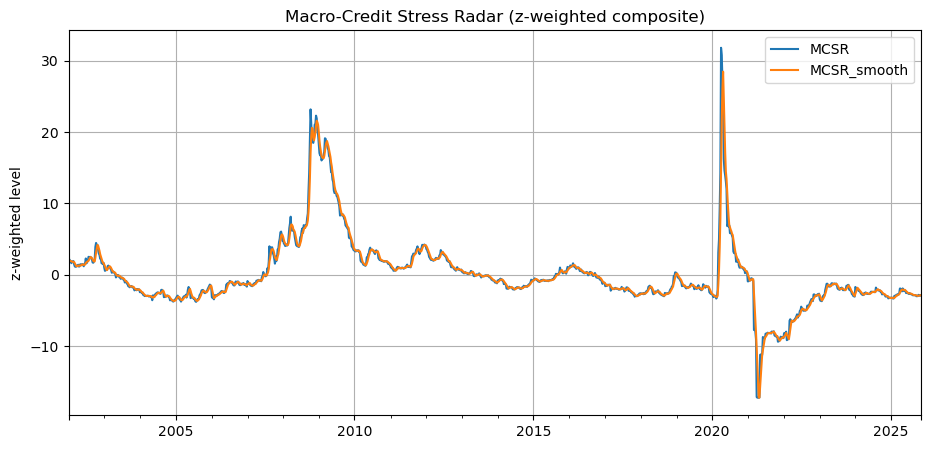

,PCE_yoy,RetailSales_yoy,UnemploymentRate,Claims,TED_spread,FedFunds,HY_OAS,IG_OAS,MortgageRate,HousePrice_Index,Claims_yoy,Unemp_3m_chg,AffordProxy,MCSR,MCSR_smooth,HYG,LQD,MBB,SH,SPY,HYG_ret,LQD_ret,MBB_ret,SH_ret,SPY_ret,HYG_cum,LQD_cum,MBB_cum,SH_cum,SPY_cum
2025-10-10,5.55264,4.9993,4.3,218000.0,0.09,4.10,3.18,0.81,6.30,1.50586,-15.830116,0.0,4.79414,-2.790275,-2.929438,79.544312,110.947563,94.938965,37.750000,653.020020,-0.011009,-0.001793,0.001998,0.024980,-0.024193,1.427864,1.882266,0.630666,-0.899958,7.586212
2025-10-17,5.55264,4.9993,4.3,218000.0,0.09,4.11,3.04,0.80,6.27,1.50586,-9.166667,0.0,4.76414,-2.834622,-2.892722,80.310410,111.794495,95.536819,37.160000,664.390015,0.009631,0.007634,0.006297,-0.015629,0.017411,1.451247,1.904268,0.640935,-0.901521,7.735710
2025-10-24,5.55264,4.9993,4.3,218000.0,0.09,4.11,2.88,0.77,6.19,1.50586,-4.385965,0.0,4.68414,-2.919842,-2.877665,80.668579,112.312614,95.696251,36.490002,677.250000,0.004460,0.004635,0.001669,-0.018030,0.019356,1.462179,1.917729,0.643673,-0.903297,7.904799
2025-10-31,5.55264,4.9993,4.3,218000.0,0.09,3.86,2.94,0.80,6.17,1.50586,0.000000,0.0,4.66414,-2.887323,-2.858015,80.389999,110.828003,95.208008,36.270000,682.059998,-0.003453,-0.013219,-0.005102,-0.006029,0.007102,1.453676,1.879160,0.635287,-0.903880,7.968043
2025-11-07,5.55264,4.9993,4.3,218000.0,0.09,3.86,3.04,0.83,6.17,1.50586,-1.357466,0.0,4.66414,-2.819975,-2.865440,80.175003,110.885002,95.224998,36.494999,683.340027,-0.002674,0.000514,0.000178,0.006203,0.001877,1.447114,1.880641,0.635579,-0.903284,7.984873


In [8]:
# Positive weights raise stress; negative weights reduce it (growth improves conditions)
WEIGHTS = {
    "PCE_yoy"         : -1.0,  # stronger consumption -> lower stress
    "RetailSales_yoy" : -0.8,  # stronger retail sales -> lower stress
    "UnemploymentRate":  1.0,  # higher unemployment -> higher stress
    "Claims_yoy"      :  0.8,  # claims rising vs last year -> higher stress
    "TED_spread"      :  1.0,  # funding stress proxy
    "FedFunds"        :  0.3,  # tighter policy -> modestly higher stress
    "HY_OAS"          :  1.2,  # junk spreads widen in stress
    "IG_OAS"          :  0.8,  # IG spreads widen in stress
    "AffordProxy"     :  0.5,  # higher -> worse housing affordability
}

# Keep only drivers available in the macro table (defensive against missing columns)
drivers = [k for k in WEIGHTS if k in macro.columns]

# Standardize each driver to z-scores for comparability 
Z = zscore(macro[drivers].copy())  # ddof=0 (population std) matches earlier helper

# Map weights to the z-scored column names (e.g., "PCE_yoy" -> "PCE_yoy_z")
w = pd.Series({f"{k}_z": WEIGHTS[k] for k in drivers})

# Weighted composite: Macro-Credit Stress Radar (MCSR) 
# Multiply elementwise and sum across columns (row-wise) to get a single level
MCSR = (Z * w).sum(axis=1).to_frame("MCSR")

# Smooth with a short moving average to reduce weekly noise (still responsive)
MCSR["MCSR_smooth"] = MCSR["MCSR"].rolling(4, min_periods=1).mean()

# Visualization 
ax = MCSR.plot(title="Macro-Credit Stress Radar (z-weighted composite)")
ax.set_ylabel("z-weighted level")
plt.show()

# Join composite back into the working panel for modeling/inspection 
data = macro.join(MCSR).join(mkts)
data.tail()


### Interpretation of the latest readings

* **Level:** Recent MCSR values around **−2.9** indicate **below-average stress** (risk-on bias). That aligns with **tight credit spreads** (HY_OAS ~3%, IG_OAS ~0.8%) and steady labor metrics (flat unemployment, improving claims YoY).
* **Smoothing:** `MCSR_smooth` closely tracks the level while dampening one-week noise; it still captures pronounced spikes (e.g., the 2008 and 2020 surges in your chart).
* **Cross-checks with markets:** Mildly positive **SPY_ret** and mixed **HYG/LQD** returns are consistent with low systemic stress but week-to-week duration/credit chop.
* **Next steps:** Consider (i) normalizing weights (e.g., sum|w|=1) for interpretability, (ii) a **contribution chart** ((Z * w) by column) to see which drivers dominate each week, and (iii) robustness checks using alternative windows or z-score methods (rolling vs full-sample).


### Regime switching on standardized MCSR (2-state Markov)

**Standardize**: Convert MCSR to z-scores for stable estimation.

**Fit model**: MarkovRegression(..., k_regimes=2, trend="c", switching_variance=True) learns two latent regimes with different means/variances.

**Smoothed probabilities**: Extract and reshape fit.smoothed_marginal_probabilities to a (nobs × k) array and wrap as a DataFrame indexed by dates.

**Identify “high-stress” state**: Compute the conditional mean of the standardized MCSR under each regime and label the regime with the higher mean as HighStress.


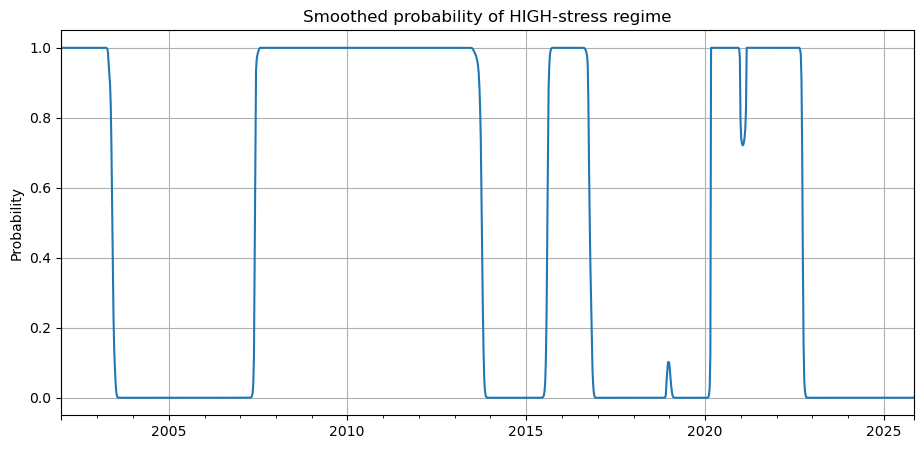

Conditional means per regime: {'Regime0': -0.407, 'Regime1': 0.437}
High-stress regime = Regime1


In [11]:
# Standardize for numerical stability
mcsr = data["MCSR"].dropna()
mcsr_std = (mcsr - mcsr.mean()) / mcsr.std(ddof=0)

# Fit model
mr  = MarkovRegression(mcsr_std.values, k_regimes=2, trend="c", switching_variance=True)
fit = mr.fit(disp=False, maxiter=200, em_iter=20)

# Smoothed marginal probabilities -> robust normalization to shape (nobs, k)
probs_raw = fit.smoothed_marginal_probabilities
probs_arr = np.array(probs_raw)
if probs_arr.ndim == 2:
    if probs_arr.shape[0] <= probs_arr.shape[1]:   # (k, nobs) -> transpose
        probs_arr = probs_arr.T
else:
    probs_arr = np.column_stack(probs_raw)

nobs, k = probs_arr.shape
regime_probs = pd.DataFrame(
    probs_arr,
    index=mcsr_std.index[-nobs:],
    columns=[f"Regime{i}" for i in range(k)]
)

# Identify high-stress regime by conditional mean of standardized MCSR
mean_r = []
for j in range(k):
    pj = regime_probs.iloc[:, j].values
    mean_r.append((mcsr_std.values[-nobs:] * pj).sum() / pj.sum())
hi = int(np.argmax(mean_r))

smoothed_probs = regime_probs.iloc[:, hi].rename("P(HighStress)")
regimes = (smoothed_probs > 0.5).astype(int).rename("Regime")

ax = smoothed_probs.plot(title="Smoothed probability of HIGH-stress regime")
ax.set_ylabel("Probability")
plt.show()

print("Conditional means per regime:", dict(zip(regime_probs.columns, np.round(mean_r, 3))))
print("High-stress regime =", regime_probs.columns[hi])


The 2-state Markov model cleanly separates **high stress (Regime1, mean +0.437)** from **low/normal (Regime0, mean −0.407)** on the standardized MCSR. It flags extended high-stress periods around the **GFC (2007–2013)** and **COVID (2020–2022)**, with only brief blips otherwise. Recently, the probability is near **0**, indicating a **benign/low-stress** backdrop consistent with tight credit spreads and steady labor data.


### Regime overlay on cumulative returns (SPY / HYG / LQD)

**Goal:** Plot cumulative total returns and shade contiguous **high-stress** periods (Regime = 1) to visually assess how each asset performs across stress regimes.


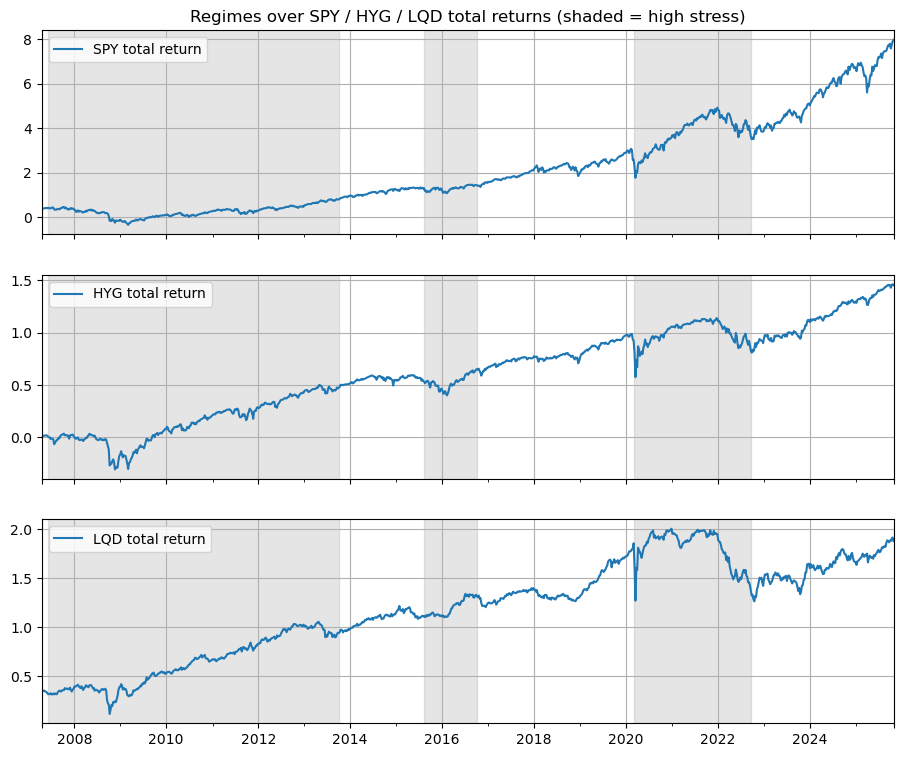

In [15]:
# Join cumulative total returns with the regime labels and drop rows that have any NaNs
overlay = data[["SPY_cum", "HYG_cum", "LQD_cum"]].join(regimes).dropna()

def shade_spans(ax, mask: pd.Series, color="grey", alpha=0.2):
    """
    Shade contiguous spans on 'ax' where 'mask' is True.
    - mask: boolean Series indexed by datetime (True = shade this date).
    - We detect contiguous blocks using a run-length encoding trick with .shift() and cumsum().
    """
    on = mask.astype(bool)
    # When the boolean state changes, start a new group; cumsum creates unique ids per run
    blocks = (on != on.shift()).cumsum()
    # Iterate contiguous True segments and shade from first to last index of each segment
    for _, seg in on[on].groupby(blocks[on]):
        ax.axvspan(seg.index[0], seg.index[-1], color=color, alpha=alpha)

# Plot three subplots sharing the x-axis (date)
fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# For each asset, plot cumulative return and shade high-stress regimes
for ax, col in zip(axes, ["SPY_cum", "HYG_cum", "LQD_cum"]):
    overlay[col].plot(ax=ax, label=col.replace("_cum", " total return"))
    shade_spans(ax, overlay["Regime"] == 1)  # shaded regions correspond to high-stress regime
    ax.legend(loc="best")

axes[0].set_title("Regimes over SPY / HYG / LQD total returns (shaded = high stress)")
plt.show()


### Driver-shock beta mapping via standardized weekly changes and ridge regression

**Goal:** Convert macro/credit **weekly changes** into a standardized feature matrix and estimate each asset’s **contemporaneous sensitivity (betas)** using a numerically stable closed-form **ridge** fit.


In [17]:
# Build a weekly driver-change feature matrix to map driver shocks -> asset returns

drivers = [k for k in ["PCE_yoy","RetailSales_yoy","UnemploymentRate","Claims_yoy",
                       "TED_spread","FedFunds","HY_OAS","IG_OAS","AffordProxy"]
           if k in data.columns]

# Weekly pct changes for drivers (levels to changes for comparability)
X = data[drivers].pct_change().replace([np.inf, -np.inf], np.nan)

# Z-standardize features (approx zero mean / unit variance)
X = (X - X.mean()) / X.std(ddof=0)

# Asset weekly returns (response block)
Y = data[["SPY_ret", "HYG_ret", "LQD_ret", "MBB_ret", "SH_ret"]]

# Align and drop missing rows
XY = X.join(Y).dropna()
X_, Y_ = XY[drivers], XY[["SPY_ret","HYG_ret","LQD_ret","MBB_ret","SH_ret"]]

# Closed-form ridge regression (small ridge for stability) to estimate betas
ridge = 1e-6
XtX = X_.T @ X_ + ridge * np.eye(X_.shape[1])
XtY = X_.T @ Y_
betas = pd.DataFrame(np.linalg.solve(XtX, XtY), index=X_.columns, columns=Y_.columns)

betas.style.format("{:+.4f}")


,SPY_ret,HYG_ret,LQD_ret,MBB_ret,SH_ret
PCE_yoy,+0.0001,+0.0000,-0.0003,-0.0001,-0.0001
RetailSales_yoy,+0.0005,+0.0001,+0.0004,+0.0002,-0.0005
UnemploymentRate,-0.0005,-0.0012,-0.0008,-0.0001,+0.0003
Claims_yoy,+0.0004,+0.0007,+0.0010,+0.0001,-0.0006
TED_spread,+0.0008,-0.0004,-0.0005,-0.0001,-0.0008
FedFunds,-0.0008,-0.0007,-0.0008,-0.0004,+0.0008
HY_OAS,-0.0166,-0.0087,+0.0035,+0.0013,+0.0169
IG_OAS,-0.0004,-0.0016,-0.0078,-0.0010,-0.0001
AffordProxy,-0.0012,-0.0014,-0.0023,-0.0004,+0.0012


Interpretation of Beta

* **Policy & funding:** **FedFunds↑** is broadly **negative** for risk and duration (SPY/LQD/MBB all < 0) and **positive** for the hedge (**SH**), whereas **TED↑** (funding stress) tilts **SPY** slightly down/up mix but overall **risk-off** (SPY small +, credit/duration −, SH −) — suggesting TED is a noisy contemporaneous signal here.
* **Growth mix:** Better **retail sales** prints associate with **risk-on** (SPY/HYG/LQD/MBB all +, SH −), while **labor deterioration** (UnemploymentRate↑, Claims_yoy↑) shows **risk-off** tilts (SPY/HYG/LQD −; SH the opposite).
* **Housing pressure:** **AffordProxy↑** (worse affordability) is **negative** for SPY/HYG/LQD/MBB and **positive** for **SH**, aligning with tightening financial conditions.


### Scenario engine: map macro-credit z-shocks to 1-week asset P/L and stress move

**Goal**: Take template (or custom) driver z-shocks, project 1-week returns via the estimated betas, and report the implied ΔMCSR (weighted stress change).

,Projected 1w return
SPY_ret,-0.041513
HYG_ret,-0.025955
LQD_ret,-0.004710
MBB_ret,0.001384
SH_ret,0.041220


,Projected ΔMCSR (z-units)
0,10.45


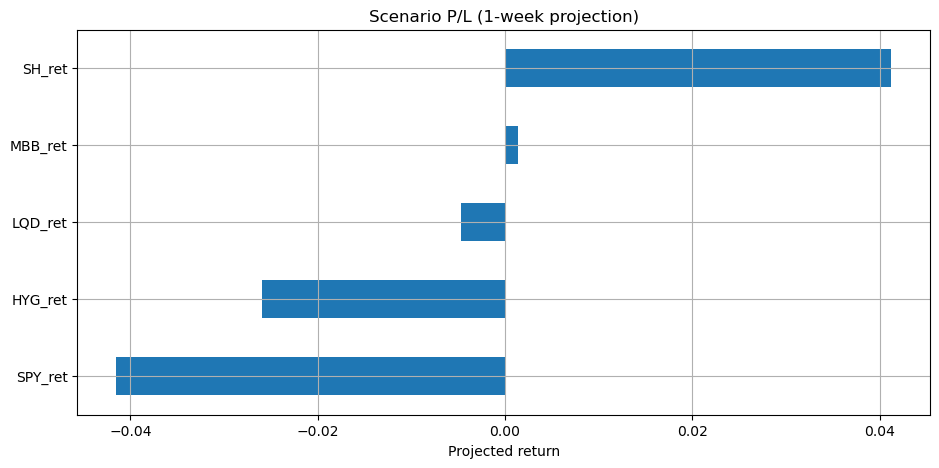

In [19]:
# Predefined macro-credit shock templates expressed in driver z-units (multiples of weekly stdev)
TEMPLATES = {
    "2008_credit_crunch": {
        "HY_OAS": +2.5, "IG_OAS": +1.5, "TED_spread": +2.0,
        "RetailSales_yoy": -1.0, "PCE_yoy": -1.0,
        "UnemploymentRate": +1.0, "Claims_yoy": +1.5, "AffordProxy": +0.5,
    },
    "covid_liquidity_shock": {
        "HY_OAS": +3.0, "IG_OAS": +2.0, "TED_spread": +2.5,
        "RetailSales_yoy": -2.5, "PCE_yoy": -2.0,
        "UnemploymentRate": +2.0, "Claims_yoy": +3.0, "AffordProxy": +0.5,
    },
    "rapid_fed_hike": {
        "FedFunds": +2.5, "IG_OAS": +0.8, "HY_OAS": +1.0, "AffordProxy": +0.8,
        "RetailSales_yoy": -0.6, "PCE_yoy": -0.6, "TED_spread": +0.6,
    },
    "oil_spike": {
        "PCE_yoy": +0.8, "RetailSales_yoy": -0.5,
        "IG_OAS": +0.4, "HY_OAS": +0.6,
        "UnemploymentRate": +0.3, "AffordProxy": +0.6,
    },
}

# Weights used in the MCSR; used to show the projected MCSR change from a given shock
WEIGHTS = {
    "PCE_yoy": -1.0, "RetailSales_yoy": -0.8, "UnemploymentRate": 1.0, "Claims_yoy": 0.8,
    "TED_spread": 1.0, "FedFunds": 0.3, "HY_OAS": 1.2, "IG_OAS": 0.8, "AffordProxy": 0.5,
}

def run_scenario(template="2008_credit_crunch", custom=None):
    """
    Map a vector of driver z-shocks into asset return projections via betas.
    Also compute the projected change in MCSR (in z-units) from the shock.
    """
    shock = TEMPLATES.get(template, {}).copy()
    if custom:
        shock.update(custom)

    # Build z-shock vector in the feature order
    zvec = pd.Series(0.0, index=drivers)
    for k, v in shock.items():
        if k in zvec.index:
            zvec[k] = v

    # Asset projection: y = betas^T * zvec  (one-week return)
    asset_proj = (betas.T @ zvec).sort_values().rename("Projected 1w return")

    # MCSR impact: weighted sum of driver z-shocks with MCSR weights
    mcsr_imp = pd.Series(WEIGHTS).reindex(drivers).fillna(0.0) @ zvec

    return zvec, asset_proj, mcsr_imp

# Example: 2008 credit crunch template
z, proj, mcsr_dz = run_scenario("2008_credit_crunch")
display(proj.to_frame(), pd.Series({"Projected ΔMCSR (z-units)": mcsr_dz}).to_frame().T)

# Visual: waterfall-style horizontal bar
proj.plot(kind="barh", title="Scenario P/L (1-week projection)")
plt.xlabel("Projected return")
plt.show()



The **2008-style credit crunch** shock projects **SPY −4.15%**, **HYG −2.60%**, mild **LQD −0.47%**, slight **MBB +0.14%**, and **SH +4.12%**, i.e., a classic **risk-off** skew where equity and high yield suffer and the inverse hedge benefits. The implied **ΔMCSR ≈ +10.45 z-units** signals an extreme stress jump (weights are unnormalized sums of z-shocks), consistent with crisis-level conditions.


### Monte Carlo fan chart from driver-shock sampling (SPY)

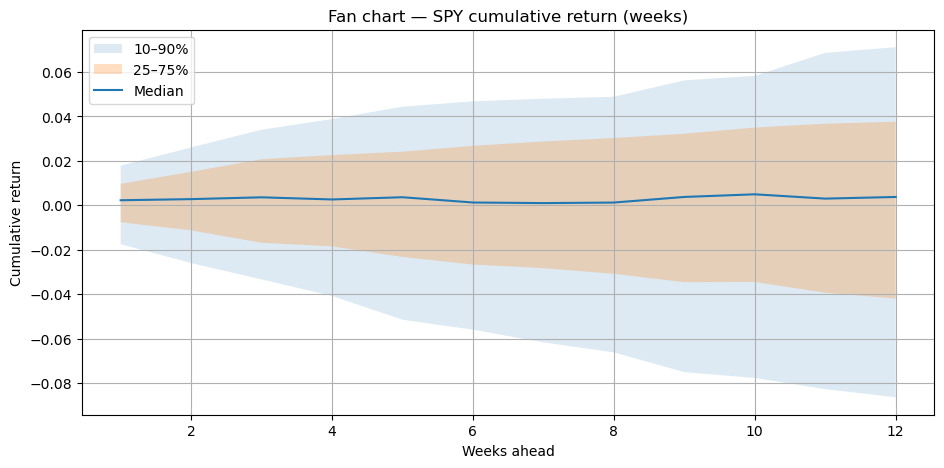

In [21]:
def fan_chart(asset="SPY_ret", weeks=12, paths=750, seed=42):
    """
    Simulate multi-week outcomes by sampling historical driver z-changes and
    mapping them to asset returns via betas. Plot 10–90% and 25–75% bands + median.
    """
    rng = np.random.default_rng(seed)
    Xhist = X_.copy()  # standardized driver changes with no NaNs

    paths_mat = []
    for _ in range(paths):
        cum = 0.0
        series = []
        for _ in range(weeks):
            # Sample one historical z-change row uniformly
            z = Xhist.sample(1, random_state=rng.integers(1e9)).values.flatten()
            # Linear map to asset return for this week
            r = betas[asset].values @ z
            cum += r
            series.append(cum)
        paths_mat.append(series)

    M = np.array(paths_mat)
    qs = np.quantile(M, [0.1, 0.25, 0.5, 0.75, 0.9], axis=0)

    # Plot the fan chart
    x = np.arange(1, weeks + 1)
    plt.fill_between(x, qs[0], qs[4], alpha=0.15, label="10–90%")
    plt.fill_between(x, qs[1], qs[3], alpha=0.25, label="25–75%")
    plt.plot(x, qs[2], label="Median")
    plt.title(f"Fan chart — {asset.replace('_ret','')} cumulative return (weeks)")
    plt.xlabel("Weeks ahead")
    plt.ylabel("Cumulative return")
    plt.legend()
    plt.show()

# Example: SPY 12-week fan
fan_chart("SPY_ret", weeks=12, paths=750)


The median 12-week path for SPY is roughly flat to slightly positive, implying **low directional conviction** under sampled macro-credit shocks. The central 25–75% band widens to about **−4% to +4%**, while the 10–90% band reaches roughly **−8% to +7%**, showing **meaningful uncertainty** with mildly better upside than downside. In short: base case ≈ sideways, but shocks can plausibly swing returns a few percent either way over a quarter.


### Portfolio risk snapshot — 1-week 95% VaR on equal-weight sleeve

Historical VaR (95%, 1w): 0.88%
Parametric VaR (95%, 1w): 0.86%


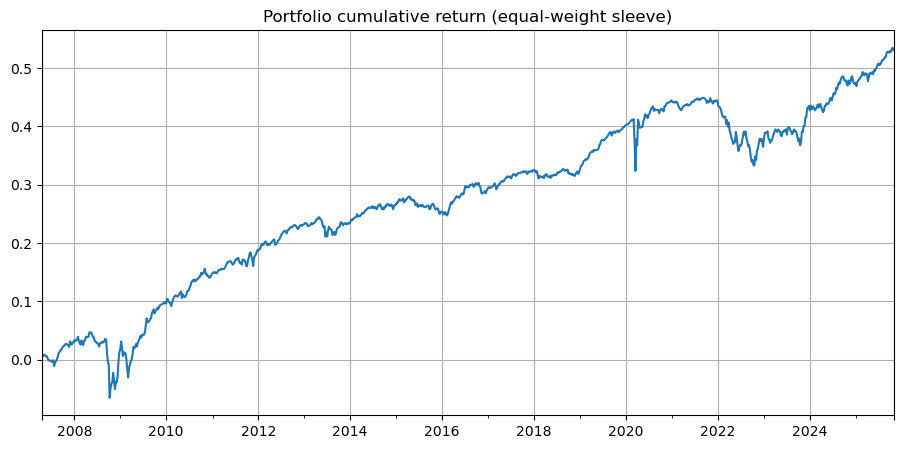

In [23]:
# Equal-weight toy sleeve: SPY/HYG/LQD/MBB/SH
weights = pd.Series({"SPY_ret": 0.2, "HYG_ret": 0.2, "LQD_ret": 0.2, "MBB_ret": 0.2, "SH_ret": 0.2})
port_ret = data[weights.index].dropna() @ weights.values

def hist_var(r: pd.Series, alpha=0.95, lookback=260):
    r = r.dropna().iloc[-lookback:]
    return -np.quantile(r, 1 - alpha)

def param_var(r: pd.Series, alpha=0.95, lookback=260):
    r = r.dropna().iloc[-lookback:]
    mu, sd = r.mean(), r.std(ddof=1)
    from scipy.stats import norm
    q = norm.ppf(1 - alpha)
    return -(mu + q * sd)

hv = hist_var(port_ret, alpha=0.95, lookback=260)
pv = param_var(port_ret, alpha=0.95, lookback=260)

print(f"Historical VaR (95%, 1w): {hv:.2%}")
print(f"Parametric VaR (95%, 1w): {pv:.2%}")

(port_ret.cumsum()).plot(title="Portfolio cumulative return (equal-weight sleeve)")
plt.show()


The sleeve’s 1-week **95% VaR is ~0.9%** (historical 0.88%, parametric 0.86%), meaning there’s a 5% chance of losing **~0.9% or worse in a week** given recent dynamics. The cumulative path is steadily positive, and the close agreement between historical and parametric VaR suggests roughly **near-normal** weekly return behavior over the last year. Treat this as **backward-looking**; stress regimes, non-normal tails, and changing correlations can push actual losses beyond these estimates.


### Radar of driver z-levels — current vs 2008 credit crunch scenario

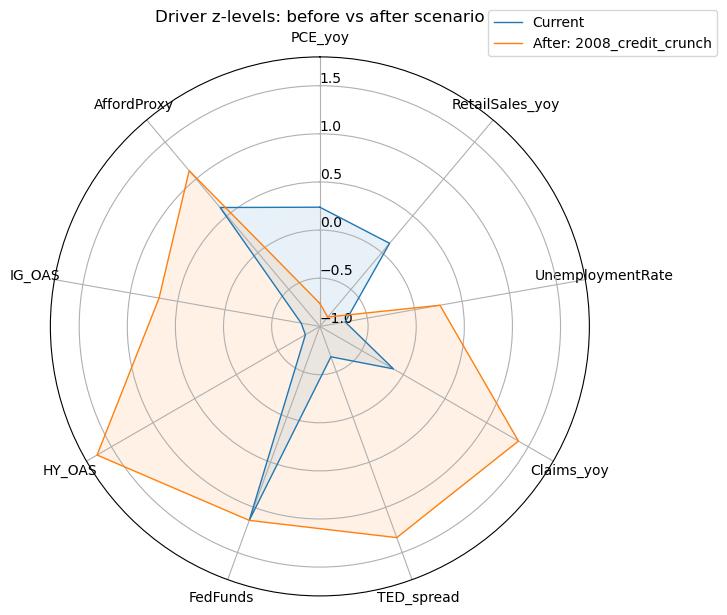

Projected ΔMCSR (z-units): +10.45


In [27]:
def plot_radar_before_after(template="2008_credit_crunch", custom=None):
    """
    Radar chart comparing current driver z-levels vs. levels after applying a scenario z-shock.
    Note: We visualize the scenario shock as a Δz added to current driver z-levels.
    """
    # 1) Baseline: driver z-levels (level z-scores)
    hist_mean = macro[drivers].mean()
    hist_std  = macro[drivers].std(ddof=0)
    baseline_z = ((macro[drivers].iloc[-1] - hist_mean) / hist_std).rename("baseline_z")

    # 2) Scenario shocks (z-units) & apply to baseline for visualization
    zvec, asset_proj, mcsr_dz = run_scenario(template, custom)
    delta_z = zvec.reindex(baseline_z.index).fillna(0.0)
    after_z = (baseline_z + delta_z).rename("after_z")

    # 3) Radar setup
    labels = list(baseline_z.index)
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the polygon

    base_vals = baseline_z.values.tolist() + baseline_z.values[:1].tolist()
    after_vals = after_z.values.tolist() + after_z.values[:1].tolist()

    # 4) Plot
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Optional radial grid
    ax.set_rlabel_position(0)

    # Baseline polygon
    ax.plot(angles, base_vals, linewidth=1, label="Current")
    ax.fill(angles, base_vals, alpha=0.1)

    # After-scenario polygon
    ax.plot(angles, after_vals, linewidth=1, label=f"After: {template}")
    ax.fill(angles, after_vals, alpha=0.1)

    ax.set_title("Driver z-levels: before vs after scenario")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
    plt.show()

    # quick text readout
    print(f"Projected ΔMCSR (z-units): {mcsr_dz:+.2f}")

# Example
plot_radar_before_after("2008_credit_crunch")


The baseline (blue) sits near neutral to slightly benign, while the 2008-style shock (orange) pushes **HY/IG OAS, TED, Claims, Unemployment, and AffordProxy sharply higher** and **PCE/RetailSales lower**, producing an implied **ΔMCSR ≈ +10.45 z-units**—an extreme jump in composite stress. This configuration is classic **risk-off**: it aligns with the earlier scenario P/L showing **SPY/HYG down, SH up**, and only muted moves in duration/MBS.

### Waterfall of MCSR shock contributions by driver


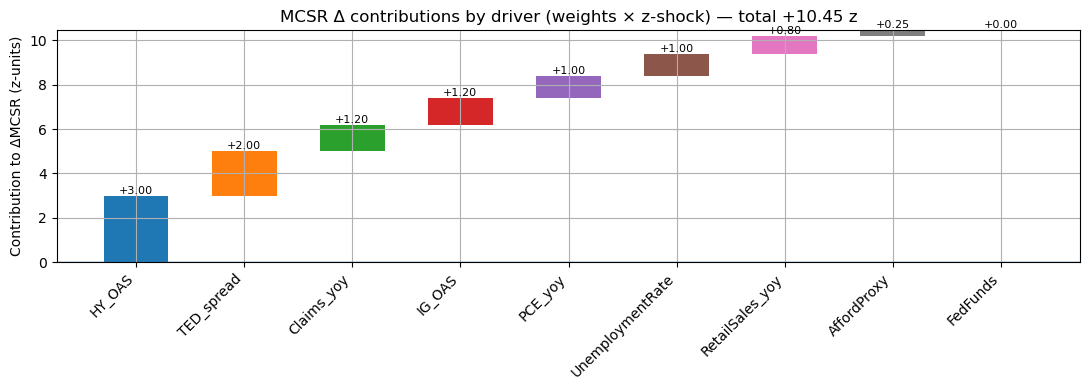

In [29]:
def plot_mcsr_contrib_waterfall(template="2008_credit_crunch", custom=None, sort_by_abs=True):
    """
    Waterfall-style chart: contribution of each driver to ΔMCSR = weight * z-shock.
    The bars accumulate left→right to the total ΔMCSR.
    """
    # 1) Scenario shocks and contributions
    zvec, asset_proj, mcsr_dz = run_scenario(template, custom)
    w = pd.Series(WEIGHTS).reindex(drivers).fillna(0.0)
    contrib = (w * zvec.reindex(drivers).fillna(0.0)).rename("contrib")

    # Order for display
    if sort_by_abs:
        contrib = contrib.reindex(contrib.abs().sort_values(ascending=False).index)

    # 2) Build waterfall components
    steps = contrib.cumsum()
    starts = pd.Series([0.0] + steps.iloc[:-1].tolist(), index=contrib.index)
    ends = steps
    widths = np.full(len(contrib), 0.6)  # bar width

    # 3) Plot
    fig, ax = plt.subplots(figsize=(11, 4))
    x = np.arange(len(contrib))

    # Individual driver bars (from start to end, positive up / negative down)
    for i, (drv, start, end) in enumerate(zip(contrib.index, starts, ends)):
        height = end - start
        # Draw a rectangle from 'start' to 'end' at position x[i]
        ax.bar(x[i], height, bottom=start, width=widths[i])
        ax.text(x[i], end, f"{contrib.iloc[i]:+.2f}", ha="center", va="bottom", fontsize=8, rotation=0)

    # Total line and label
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(contrib.index, rotation=45, ha="right")
    ax.set_title(f"MCSR Δ contributions by driver (weights × z-shock) — total {mcsr_dz:+.2f} z")
    ax.set_ylabel("Contribution to ΔMCSR (z-units)")
    plt.tight_layout()
    plt.show()

plot_mcsr_contrib_waterfall("2008_credit_crunch")


The 2008-style shock is driven primarily by **HY_OAS (+3.00 z)** and **TED spread (+2.00 z)**, with sizable support from **IG_OAS (+1.20 z)** and **Claims_yoy (+1.20 z)**—i.e., credit and funding stress dominate the move. Declines in **PCE_yoy (+1.00 z)** and **RetailSales_yoy (+0.80 z)** add to stress because their weights are negative, while **UnemploymentRate (+1.00 z)** and **AffordProxy (+0.25 z)** contribute modestly; **FedFunds** is neutral in this template. The bars sum to **+10.45 z**, matching the total ΔMCSR shown—an extreme, crisis-like surge.


# **Summary**

I assembled a weekly macro-credit dataset (FRED + ETFs), created a z-weighted **Macro-Credit Stress Radar (MCSR)**, fit a **2-state Markov regime** model, estimated **driver→asset betas** via ridge, and built a **scenario engine** (with visuals: overlays, fan chart, radar, waterfall) plus a simple sleeve **VaR**.

**Key Results.**

* Clear regime split: **High-stress mean +0.44σ** vs **Low-stress −0.41σ**; GFC and COVID flagged; **recent stress near 0**.
* Betas show **credit/funding dominate**: HY_OAS most negative for SPY/HYG; SH hedges.
* 2008-style shock: **SPY −4.15%**, **HYG −2.60%**, **SH +4.12%**; **ΔMCSR +10.45σ** driven by HY_OAS/TED/IG_OAS.
* 12-week SPY fan: median ~flat; **25–75% ≈ −4% to +4%**.
* Equal-weight sleeve **VaR (95%, 1w) ≈ 0.9%**.

**Conclusion.** The composite and regime model behave coherently: systemic episodes spike stress; today looks **benign**. Credit/funding shocks explain most downside; the hedge sleeve works as expected.

**Next steps.** Roll to **real-time** (rolling z-scores, walk-forward), test a **3-state** model, add **by-regime performance** + out-of-sample AUC, wire an **interactive Streamlit** app and scheduled refresh.

